# Project Implementation : Battery Health Prediction
Adan Ordonez

## Imports
Will start by importing python libraries for data handling, visualization, and machine learning.
We will use:
- `scikit-learn` for pipelines, preprocessing, and models
- `xgboost` for gradient-boosted model
- `imblearn.pipeline` to setup pipline

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings('ignore')

## Data

The Battery Aging dataset from [NASA's Ames Prognostics Data Repository](https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/). The original data is in `.mat` format. Fortunately, we found its cleaned version ready to do analysis and modeling in [Kaggle](https://www.kaggle.com/code/kenggle/nasa-battery-life-prediction-dataset-cleaning). So, we use this version of dataset in our project.

`metadata.csv` contains information about each battery test cycle. This dataset includes identifiers, test conditions, and references to the individual CSV files that store time series data for voltage, current, and temperature.

In [ ]:
metadata_df = pd.read_csv('metadata.csv')

metadata_df.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


## Feature Extraction
Each battery's discharge CSV file contains detailed time-series data. These are in the `data` folder.
We summarize each file into a few statistical features that describe its voltage, temperature, and discharge duration.
These features will be our numerical predictors for Remaining Useful Life (RUL) and Capacity degradation models.

In [ ]:
discharge = metadata_df[metadata_df['type'] == 'discharge'].copy()
csv_files_path = 'data/'
csv_files = discharge['filename'].tolist()
csv_files[:5]

['00001.csv', '00005.csv', '00007.csv', '00009.csv', '00011.csv']

In [ ]:
# For loop to extract features

for file in csv_files:
    temp_df = pd.read_csv(os.path.join(csv_files_path, file))

    # Extract summary features from the discharge cycle
    discharge_time = temp_df['Time'].max()
    avg_voltage = temp_df['Voltage_measured'].mean()
    min_voltage = temp_df['Voltage_measured'].min()
    avg_temperature = temp_df['Temperature_measured'].mean()
    max_temperature = temp_df['Temperature_measured'].max()

    # Store the features back into the main metadata DataFrame
    metadata_df.loc[metadata_df['filename']==file, 'discharge_time'] = discharge_time
    metadata_df.loc[metadata_df['filename']==file, 'avg_voltage'] = avg_voltage
    metadata_df.loc[metadata_df['filename']==file, 'min_voltage'] = min_voltage
    metadata_df.loc[metadata_df['filename']==file, 'avg_temperature'] = avg_temperature
    metadata_df.loc[metadata_df['filename']==file, 'max_temperature'] = max_temperature

**Features we extracted:**
- `discharge_time`: Total time until the battery reaches the cut-off voltage. We take the `max` so it indicates how long the battery lasted in that cycle.
- `avg_voltage`: Average voltage during discharge can reflect the overall voltage. This can drop as batteries age.
- `min_voltage`: The lowest voltage reached.
- `avg_temperature`: Mean temperature during the cycle.
- `max_temperature`: Peak temperature reached during the cycle.

## Data Preprocessing

In [ ]:
discharge = metadata_df[metadata_df['type'] == 'discharge'].copy()

**Compute Remaining Useful Life (RUL)**

In [ ]:
# RUL = max(test_id) - current test_id
discharge['RUL'] = discharge.groupby('battery_id')['test_id'].transform('max') - discharge['test_id']

In [ ]:
# Drop columns that are not required
discharge.drop(['Re', 'Rct', 'type', 'start_time', 'uid', 'filename', 'ambient_temperature'],
               axis=1, inplace=True)

**Label encoding:**
The original `battery_id` is a string like `B0005`, `B0007`, etc. So we will convert these into integers. Numeric `battery_id` works with `OneHotEncoder` in the pipeline.

In [ ]:
battery_map = {bid: i+1 for i, bid in enumerate(discharge['battery_id'].unique())}
discharge['battery_id'] = discharge['battery_id'].map(battery_map)
discharge.head()

,battery_id,test_id,Capacity,discharge_time,avg_voltage,min_voltage,avg_temperature,max_temperature,RUL
0,1,0,1.6743047446975208,6436.141,3.475266,2.470612,8.272423,12.376816,180
4,1,4,1.5243662105099023,5650.265,3.476559,2.477662,8.210715,11.314903,176
6,1,6,1.5080762969973425,5590.907,3.470767,2.470710,7.954455,11.624528,174
8,1,8,1.4835577960067696,5543.610,3.467551,2.465458,7.985865,11.092924,172
10,1,10,1.4671391666146525,5499.046,3.462839,2.465765,8.009427,11.020979,170


**Missing values**
`Capacity` has missing values. We will turn `[]`s into `NaN`s. This will allow us for imputation.

In [ ]:
discharge['Capacity'].astype(str).value_counts().head()

Capacity
[]                    25
0                     19
1.6743047446975208     1
1.4675164935067897     1
1.4935201918040188     1
Name: count, dtype: int64

In [ ]:
discharge['Capacity'] = discharge['Capacity'].replace('[]', np.nan)
discharge['Capacity'] = pd.to_numeric(discharge['Capacity'], errors='coerce')

discharge['Capacity'].isna().sum()

25

In [ ]:
discharge['RUL'].astype(str).value_counts().head()

RUL
0     34
12    31
66    30
54    30
38    29
Name: count, dtype: int64

In [ ]:
discharge['RUL'].isna().sum()

0

## Correlation analysis
We will see how the above extracted features are correlated with the target variables (RUL and Capacity).

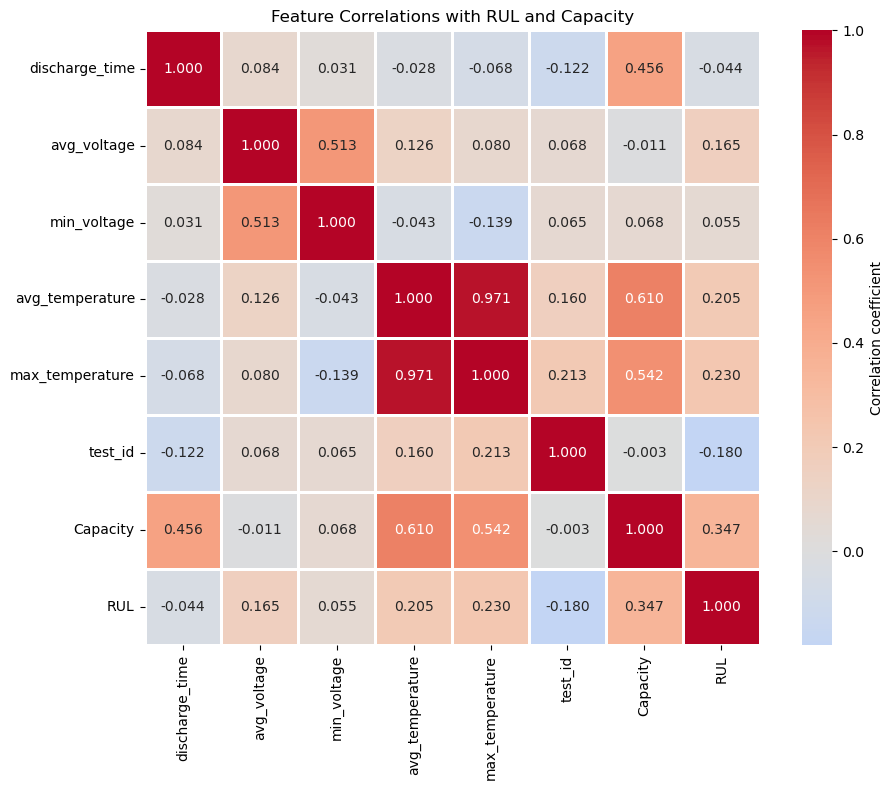

In [ ]:
# Select the features
cols_for_corr = ['discharge_time', 'avg_voltage', 'min_voltage',
                 'avg_temperature', 'max_temperature',
                 'test_id', 'Capacity', 'RUL']

# Build the correlation matrix
corr_matrix = discharge[cols_for_corr].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.3f',
            linewidths=1,
            cbar_kws={'label': 'Correlation coefficient'},
            square=True)

plt.title('Feature Correlations with RUL and Capacity')
plt.tight_layout()
plt.show()

**Correlation with RUL:**

In [ ]:
corr_matrix['RUL'].drop('Capacity').sort_values(ascending=False)

RUL                1.000000
max_temperature    0.229531
avg_temperature    0.204883
avg_voltage        0.164615
min_voltage        0.055350
discharge_time    -0.043840
test_id           -0.180441
Name: RUL, dtype: float64

**Correlation with Capacity:**

In [ ]:
corr_matrix['Capacity'].drop('RUL').sort_values( ascending=False)

Capacity           1.000000
avg_temperature    0.609803
max_temperature    0.542182
discharge_time     0.455797
min_voltage        0.068191
test_id           -0.003131
avg_voltage       -0.011349
Name: Capacity, dtype: float64

We can see that `RUL` and `Capacity` are both positively correlated with `max_temperature` and `avg_temperature`. `RUL` is the most positively correlated with `max_temperature` and `Capacity` is the most positively correlated with `avg_temperature`. `RUL` is somewhat positively correlated with `avg_voltage` and `min_voltage`, while negatively correlated with `discharge_time` and `test_id`.

On the other hand, `Capacity` is positively correlated with `discharge_time`, somewhat positively correlated with `min_voltage`, and negatively correlated with `test_id` and `avg_voltage`. It is interesting how it can be positively correlated with `min_voltage`, but negatively correlated with `avg_voltage`.

## Data split

In [ ]:
# Split the data into train and test sets

train_set, test_set = train_test_split(discharge, test_size=0.2, random_state=42)
print(f"Training set: {len(train_set)} samples")
print(f"Test set: {len(test_set)} samples")

Training set: 2235 samples
Test set: 559 samples


## Setup pipeline

In [ ]:
categorical_columns = ["battery_id"]
continuous_columns = ["discharge_time", "avg_voltage", "min_voltage", "avg_temperature", "max_temperature"]

We will use `KNNImputer` because battery cycles are similar within the same battery. So, cycles from the same battery have almost identical patterns, thus KNN with `n_neighbors=5` finds the 5 most similar past cycles and use their values.

We will use `StandardScaler` to normalize numeric ranges.

Even though we converted `battry_id` to numbers, there is no ordinal relationship. One-hot encoding will prevent the model form assuming `B0055` is greater than `B0005`. `handle_unknown='ignore'` makes it robust if a new battery appears in test data.

The we apply `ColumnTransformer` over the pipelines and corresponding columns.

In [ ]:
num_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, continuous_columns),
    ('cat', cat_pipeline, categorical_columns)
])

## Model 1: RUL Prediction

Along with the target variable `RUL`, we drop `Capacity` and `test_id`. We won't use `Capacity` because we are peredicting that next. We won't use `test_id` because we derived `RUL` out of it.

In [ ]:
X_train_rul = train_set.drop(['RUL', 'Capacity', 'test_id'], axis=1)
y_train_rul = train_set['RUL']
X_test_rul = test_set.drop(['RUL', 'Capacity', 'test_id'], axis=1)
y_test_rul = test_set['RUL']

We will tran four regression models to predict RUL:

- Linear Regression: simple baseline for interpretability
- Random Forest: ensemble for decision trees, good for non-linear effects
- XGBoost: optimized gradient boosting, effective on structured
- Neural Network: we use `MLPRegressor` as this is a regression task

We will also use grid search for hyperparameter tuning.

In [ ]:
lr_pipe_rul = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipe_rul = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

xgb_pipe_rul = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42))
])

nn_pipe_rul = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(random_state=42, max_iter=1000))
])

rf_params = {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [10, 20]}
xgb_params = {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [3, 6]}

# parameters for neural network
nn_params = {
    'regressor__hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25)],
    'regressor__alpha': [0.0001, 0.001, 0.01],
    'regressor__learning_rate_init': [0.001, 0.01]
}

# hyperparameter tuning with grid search
rf_grid_rul = GridSearchCV(rf_pipe_rul, rf_params, cv=3, n_jobs=-1)
xgb_grid_rul = GridSearchCV(xgb_pipe_rul, xgb_params, cv=3, n_jobs=-1)
nn_grid_rul = GridSearchCV(nn_pipe_rul, nn_params, cv=3, n_jobs=-1, verbose=1)

lr_pipe_rul.fit(X_train_rul, y_train_rul)
rf_grid_rul.fit(X_train_rul, y_train_rul)
xgb_grid_rul.fit(X_train_rul, y_train_rul)
nn_grid_rul.fit(X_train_rul, y_train_rul)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['discharge_time',
                                                                          'avg_voltage',
                                                                          'min_voltage',
                                                                          'avg_temperature',
                                                                          'max_temperature']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['battery_id'])])),
                                       ('regressor',
                                        MLPRegressor(max_iter=1000,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01],
                         'regressor__hidden_layer_sizes': [(100,), (100, 50),
                                                           (100, 50, 25)],
                         'regressor__learning_rate_init': [0.001, 0.01]},
             verbose=1)

## Evaluate RUL Models
We will use the following metrics for model evaluation:
- MAE (Mean Absolute Error)
- MSE (Mean Square Error)
- R-squared Score

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Predicts on test set and prints MAE, RMSE, and R-squared score.

    Args:
        model
        X_test
        y_test
        model_name
    """

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

In [ ]:
print(evaluate_model(lr_pipe_rul, X_test_rul, y_test_rul, "Linear Regression (RUL)"))
print(evaluate_model(rf_grid_rul.best_estimator_, X_test_rul, y_test_rul, "Random Forest (RUL)"))
print(evaluate_model(xgb_grid_rul.best_estimator_, X_test_rul, y_test_rul, "XGBoost (RUL)"))
print(evaluate_model(nn_grid_rul.best_estimator_, X_test_rul, y_test_rul, "Neural Network (RUL)"))

{'Model': 'Linear Regression (RUL)', 'MAE': 84.72438149113924, 'RMSE': 111.93622707323478, 'R2': 0.40256364167434844}
{'Model': 'Random Forest (RUL)', 'MAE': 14.263675753990784, 'RMSE': 26.29243921114665, 'R2': 0.9670381121745683}
{'Model': 'XGBoost (RUL)', 'MAE': 17.380015019147468, 'RMSE': 29.985725909642966, 'R2': 0.9571274363352991}
{'Model': 'Neural Network (RUL)', 'MAE': 19.970015067907138, 'RMSE': 34.1275210844308, 'R2': 0.9444658911251189}


We will visualize the results later.

## Model 2: Capacity Prediction

We carry out the similar process of dropping out some columns as in the RUL model train process.

In [ ]:
train_cap = train_set.dropna(subset=['Capacity'])
test_cap = test_set.dropna(subset=['Capacity'])

X_train_cap = train_cap.drop(['RUL', 'Capacity', 'test_id'], axis=1)
y_train_cap = train_cap['Capacity']
X_test_cap = test_cap.drop(['RUL', 'Capacity', 'test_id'], axis=1)
y_test_cap = test_cap['Capacity']

Train the 3 models in a similar way.

In [ ]:
lr_pipe_cap = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipe_cap = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

xgb_pipe_cap = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42))
])

nn_pipe_cap = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(random_state=42, max_iter=1000))
])

# hyperparameter tuning with grid search
rf_grid_cap = GridSearchCV(rf_pipe_cap, rf_params, cv=3, n_jobs=-1)
xgb_grid_cap = GridSearchCV(xgb_pipe_cap, xgb_params, cv=3, n_jobs=-1)
nn_grid_cap = GridSearchCV(nn_pipe_cap, nn_params, cv=3, n_jobs=-1, verbose=1)

lr_pipe_cap.fit(X_train_cap, y_train_cap)
rf_grid_cap.fit(X_train_cap, y_train_cap)
xgb_grid_cap.fit(X_train_cap, y_train_cap)
nn_grid_cap.fit(X_train_cap, y_train_cap)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['discharge_time',
                                                                          'avg_voltage',
                                                                          'min_voltage',
                                                                          'avg_temperature',
                                                                          'max_temperature']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['battery_id'])])),
                                       ('regressor',
                                        MLPRegressor(max_iter=1000,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01],
                         'regressor__hidden_layer_sizes': [(100,), (100, 50),
                                                           (100, 50, 25)],
                         'regressor__learning_rate_init': [0.001, 0.01]},
             verbose=1)

## Evaluate Capacity models

We use the same evaluation function as above and calculate MAE, MSE, and R-squared score.3

In [ ]:
print(evaluate_model(lr_pipe_cap, X_test_cap, y_test_cap, "Linear Regression (Capacity)"))
print(evaluate_model(rf_grid_cap.best_estimator_, X_test_cap, y_test_cap, "Random Forest (Capacity)"))
print(evaluate_model(xgb_grid_cap.best_estimator_, X_test_cap, y_test_cap, "XGBoost (Capacity"))
print(evaluate_model(nn_grid_cap.best_estimator_, X_test_cap, y_test_cap, "Neural Network (Capacity)"))

{'Model': 'Linear Regression (Capacity)', 'MAE': 0.11088303327105195, 'RMSE': 0.1744135075762195, 'R2': 0.8572429839507097}
{'Model': 'Random Forest (Capacity)', 'MAE': 0.02088508067404572, 'RMSE': 0.08882581177961052, 'R2': 0.9629732494928016}
{'Model': 'XGBoost (Capacity', 'MAE': 0.02410800903285945, 'RMSE': 0.07819775574199349, 'R2': 0.9713037063714733}
{'Model': 'Neural Network (Capacity)', 'MAE': 0.047380612922399916, 'RMSE': 0.08643508399935347, 'R2': 0.9649395612885109}


## Visualization

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("husl")

### RUL Model Predictions vs Actual

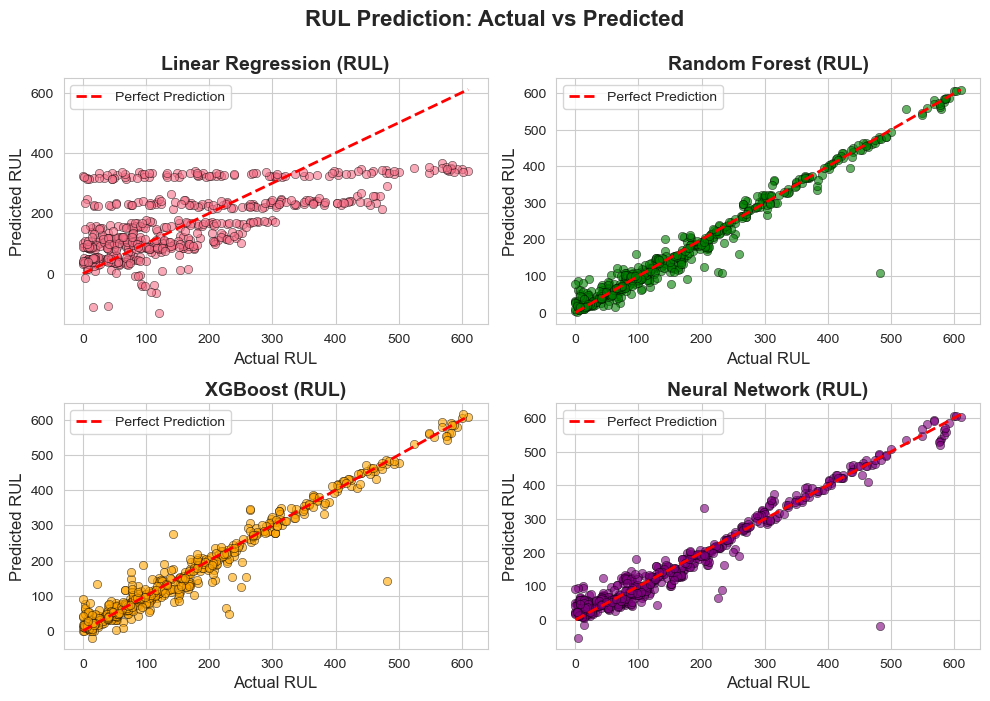

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Linear Regression RUL
y_pred_lr = lr_pipe_rul.predict(X_test_rul)
sns.scatterplot(x=y_test_rul, y=y_pred_lr, alpha=0.6, edgecolor='k', ax=axes[0, 0])
axes[0, 0].plot([y_test_rul.min(), y_test_rul.max()],
                [y_test_rul.min(), y_test_rul.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL', fontsize=12)
axes[0, 0].set_ylabel('Predicted RUL', fontsize=12)
axes[0, 0].set_title('Linear Regression (RUL)', fontsize=14, fontweight='bold')
axes[0, 0].legend()

# Random Forest RUL
y_pred_rf = rf_grid_rul.best_estimator_.predict(X_test_rul)
sns.scatterplot(x=y_test_rul, y=y_pred_rf, alpha=0.6, edgecolor='k', color='green', ax=axes[0, 1])
axes[0, 1].plot([y_test_rul.min(), y_test_rul.max()],
                [y_test_rul.min(), y_test_rul.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual RUL', fontsize=12)
axes[0, 1].set_ylabel('Predicted RUL', fontsize=12)
axes[0, 1].set_title('Random Forest (RUL)', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# XGBoost RUL
y_pred_xgb = xgb_grid_rul.best_estimator_.predict(X_test_rul)
sns.scatterplot(x=y_test_rul, y=y_pred_xgb, alpha=0.6, edgecolor='k', color='orange', ax=axes[1, 0])
axes[1, 0].plot([y_test_rul.min(), y_test_rul.max()],
                [y_test_rul.min(), y_test_rul.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual RUL', fontsize=12)
axes[1, 0].set_ylabel('Predicted RUL', fontsize=12)
axes[1, 0].set_title('XGBoost (RUL)', fontsize=14, fontweight='bold')
axes[1, 0].legend()

# Neural Network RUL
y_pred_nn = nn_grid_rul.best_estimator_.predict(X_test_rul)
sns.scatterplot(x=y_test_rul, y=y_pred_nn, alpha=0.6, edgecolor='k', color='purple', ax=axes[1, 1])
axes[1, 1].plot([y_test_rul.min(), y_test_rul.max()],
                [y_test_rul.min(), y_test_rul.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual RUL', fontsize=12)
axes[1, 1].set_ylabel('Predicted RUL', fontsize=12)
axes[1, 1].set_title('Neural Network (RUL)', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.suptitle('RUL Prediction: Actual vs Predicted', fontsize=16, y=0.995, fontweight='bold')
plt.tight_layout()
plt.show()

### Capacity Model Predictions vs Actual

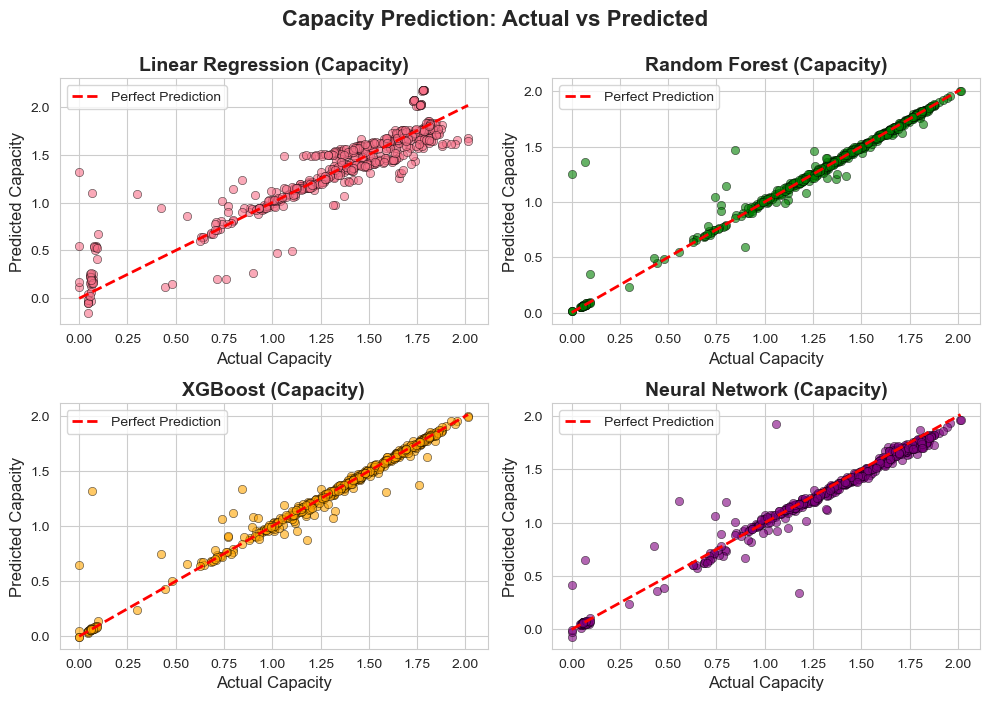

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Linear Regression Capacity
y_pred_lr_cap = lr_pipe_cap.predict(X_test_cap)
sns.scatterplot(x=y_test_cap, y=y_pred_lr_cap, alpha=0.6, edgecolor='k', ax=axes[0, 0])
axes[0, 0].plot([y_test_cap.min(), y_test_cap.max()],
                [y_test_cap.min(), y_test_cap.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Capacity', fontsize=12)
axes[0, 0].set_ylabel('Predicted Capacity', fontsize=12)
axes[0, 0].set_title('Linear Regression (Capacity)', fontsize=14, fontweight='bold')
axes[0, 0].legend()

# Random Forest Capacity
y_pred_rf_cap = rf_grid_cap.best_estimator_.predict(X_test_cap)
sns.scatterplot(x=y_test_cap, y=y_pred_rf_cap, alpha=0.6, edgecolor='k', color='green', ax=axes[0, 1])
axes[0, 1].plot([y_test_cap.min(), y_test_cap.max()],
                [y_test_cap.min(), y_test_cap.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Capacity', fontsize=12)
axes[0, 1].set_ylabel('Predicted Capacity', fontsize=12)
axes[0, 1].set_title('Random Forest (Capacity)', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# XGBoost Capacity
y_pred_xgb_cap = xgb_grid_cap.best_estimator_.predict(X_test_cap)
sns.scatterplot(x=y_test_cap, y=y_pred_xgb_cap, alpha=0.6, edgecolor='k', color='orange', ax=axes[1, 0])
axes[1, 0].plot([y_test_cap.min(), y_test_cap.max()],
                [y_test_cap.min(), y_test_cap.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Capacity', fontsize=12)
axes[1, 0].set_ylabel('Predicted Capacity', fontsize=12)
axes[1, 0].set_title('XGBoost (Capacity)', fontsize=14, fontweight='bold')
axes[1, 0].legend()

# Neural Network Capacity
y_pred_nn_cap = nn_grid_cap.best_estimator_.predict(X_test_cap)
sns.scatterplot(x=y_test_cap, y=y_pred_nn_cap, alpha=0.6, edgecolor='k', color='purple', ax=axes[1, 1])
axes[1, 1].plot([y_test_cap.min(), y_test_cap.max()],
                [y_test_cap.min(), y_test_cap.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Capacity', fontsize=12)
axes[1, 1].set_ylabel('Predicted Capacity', fontsize=12)
axes[1, 1].set_title('Neural Network (Capacity)', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.suptitle('Capacity Prediction: Actual vs Predicted', fontsize=16, y=0.995, fontweight='bold')
plt.tight_layout()
plt.show()

### Model Comparison Bar Charts

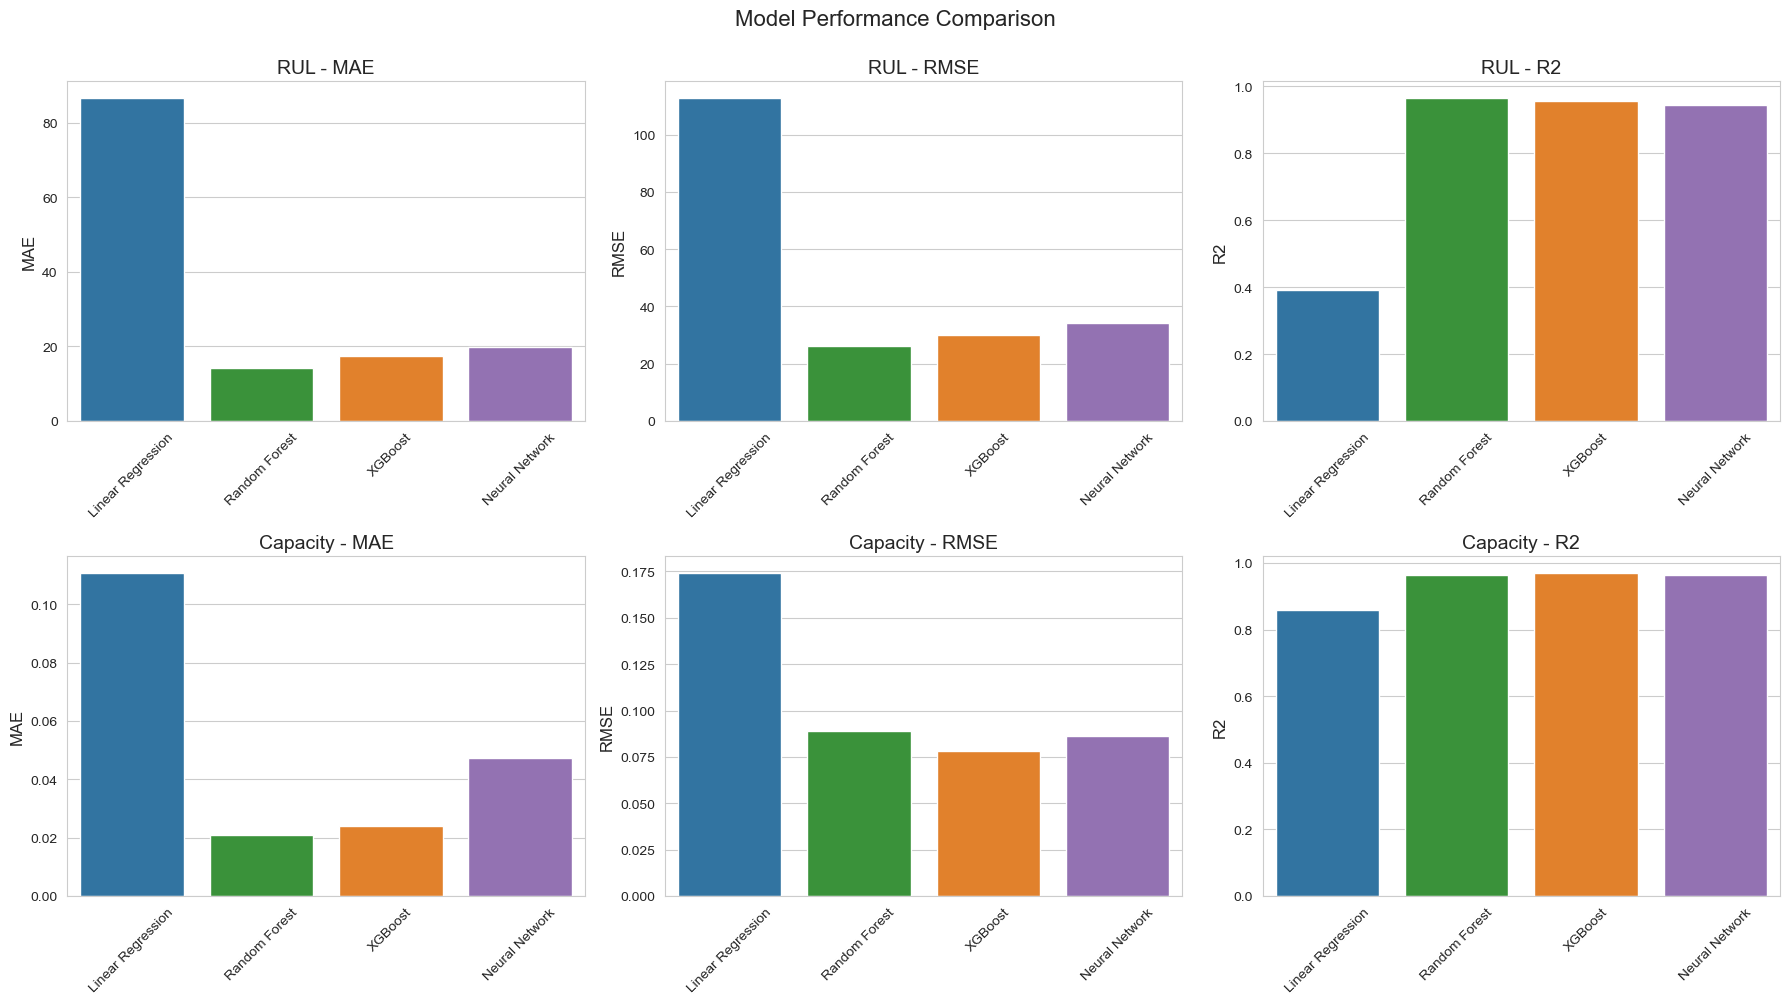

In [ ]:
rul_results = pd.DataFrame([
    evaluate_model(lr_pipe_rul, X_test_rul, y_test_rul, "Linear Regression"),
    evaluate_model(rf_grid_rul.best_estimator_, X_test_rul, y_test_rul, "Random Forest"),
    evaluate_model(xgb_grid_rul.best_estimator_, X_test_rul, y_test_rul, "XGBoost"),
    evaluate_model(nn_grid_rul.best_estimator_, X_test_rul, y_test_rul, "Neural Network")
])

cap_results = pd.DataFrame([
    evaluate_model(lr_pipe_cap, X_test_cap, y_test_cap, "Linear Regression"),
    evaluate_model(rf_grid_cap.best_estimator_, X_test_cap, y_test_cap, "Random Forest"),
    evaluate_model(xgb_grid_cap.best_estimator_, X_test_cap, y_test_cap, "XGBoost"),
    evaluate_model(nn_grid_cap.best_estimator_, X_test_cap, y_test_cap, "Neural Network")
])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# RUL Metrics
metrics = ['MAE', 'RMSE', 'R2']
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd']

for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=rul_results, palette=colors, ax=axes[0, i])
    axes[0, i].set_ylabel(metric, fontsize=12)
    axes[0, i].set_title(f'RUL - {metric}', fontsize=14)
    axes[0, i].tick_params(axis='x', rotation=45)
    axes[0, i].set_xlabel('')

# Capacity Metrics
for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=cap_results, palette=colors, ax=axes[1, i])
    axes[1, i].set_ylabel(metric, fontsize=12)
    axes[1, i].set_title(f'Capacity - {metric}', fontsize=14)
    axes[1, i].tick_params(axis='x', rotation=45)
    axes[1, i].set_xlabel('')

plt.suptitle('Model Performance Comparison', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## Discussion

In this project, we evaluated four machine learning approaches for predicting battery Remaining Useful Life (RUL) and Capacity degradation using NASA's Battery Aging dataset.

The results suggest that the ensemble and gradient boosting methods outperform the linear regression. This shows the battery degradation process follows non-linear nature.

**RUL Prediction Performance**

For Remaining Useful Life (RUL) prediction, Random Forest was the top performer with an R-squared of 0.967, MAE of 14.26 cycles, and RMSE of 26.29 cycles.

The ensemble of decision trees effectively handles the interaction effects between voltage, temperature, and discharge characteristics.

XGBoost was the second with an R-squared of 0.957, MAE of 17.38, and RMSE of 29.99. The gradient boosting framework's sequential error correction mechanism proved effective for this regression task.

Neural Network showed competitive results with an R-squared of 0.944, MAE of 19.97, and RMSE of 34.13. The relatively small dataset size (2,235 training samples) may have limited the neural network's ability to fully leverage its capacity for learning complex patterns.

Linear Regression significantly underperformed with an R-squared of only 0.403, MAE of 84.72, and RMSE of 111.94. This poor performance confirms that battery degradation follows highly non-linear patterns that simple linear models cannot capture.

**Capacity Prediction Performance**

For the Capacity prediction, XGBoost achieved the best results with an R-squared of 0.971, MAE of 0.024, and RMSE of 0.078. This performance suggests that gradient boosting's iterative refinement approach is particularly well-suited for capacity estimation. Subtle patterns in voltage and temperature profiles can significantly impact predictions.

Neural Network was the second best with an R-squared of 0.965, MAE of 0.047, and RMSE of 0.086.

Random Forest also did well with an R-squared of 0.963, MAE of 0.021, and RMSE of 0.089.

The consistency between training and test performance among the above models suggests good generalization without overfitting.

Linear Regression showed improvement compared to RUL but had the lowest performance with an R-squared of 0.857, MAE of 0.111, and RMSE of 0.174. While better than its RUL performance, the model still fails to capture the non-linear capacity degradation patterns.

## Limitations and Conclusion

We had several limitations.

**Dataset Size:** With only 2,794 samples, the neural network is an over kill for this task as Random Forest and XGBoost already perform well in prediction. We also had a single data source.

**Feature Engineering:** Our statistical features (mean, min, max) simplify time-series data. We could look into data that captures features like trend or seasonality.

This project showed us that battery health follows non-linear pettern. Hence, ensemble methods such as Random Forest and XGBoost performed better compared to linear method. Our study can inform battery maintenance or management systems with a foundation for predictive strategies in real-world applications.

Future work should focus on expanding the dataset, and validating models across diverse battery types beyond a single data source.